# Emission Rates with McBEF Inputs and Freitas Plume Rise VMD

This notebook computes CO and CO$_2$ emission rates using McBEF outout as well the vertical mass distribution from the Freitas PR.


# Comparison of McBEF vs Classic Plume Rise Simulations

This notebook compares the resulting Plume Rise simulations.

* Freitas PR model with McBEF flaming heat flux
* Freitas PR model with classical heat flux assumptions implemented in plumerise.bioma

Notice that the classic flaming heatfluxes and the fraction of flaming/smoldering fires are prescribed as a function of biome type.

In [1]:
import os
import sys

#import importlib
#importlib.reload(kde)

from IPython.display import display, Markdown

import numpy as np
import xarray as xr
import yaml

from datetime import datetime, timedelta

from pyobs     import mcbef as mb
from pyobs     import kde

from plumerise import bioma   as bm
from plumerise import freitas as pr

import matplotlib.pyplot as plt
%matplotlib inline 

lb, mode, ub = (0, 1, 2)  # indices for McBEF stats


## Load data

In [2]:
def getFiresMetOneDay(day,Verbose=False):
    """
    Ingests McBEF retrievals and sampled meteorology for one day.
    """

    l2_dirn = '/css/viirs/data/Level2/VNP47MCBEF/2019/'
    f_fname = l2_dirn + 'VNP47MCBEF.Stats.A2019%03d.0000_2400.Uniform_v_1_0_0.nc'%day
    m_fname = l2_dirn + 'VNP47MCBEF.Met.A2019%03d.nc'%day
    p_fname = './VNP47MCBEF.PR.A2019%03d.nc'%day
    p_20ha_fname = './VNP47MCBEF.PR_20ha.A2019%03d.nc'%day
    
    f = mb.open_dataset(f_fname) # fire property statistics
    m = xr.open_dataset(m_fname) # sample met fields
    p = xr.open_dataset(p_fname)
    p_20ha = xr.open_dataset(p_20ha_fname)
    
    # Only good QA
    # ------------
    N = f.dims['fire']
    I = (f.QA_flag<mb.QA['Bowtie'])
    J = np.arange(N,dtype=int)[I]
    f = f.isel(fire=J)
    m = m.isel(time=J)
    
    failed = int(0.5 + 100 * (N - f.dims['fire']) / N)
    
    if p.dims['time'] != m.dims['time']:
        raise ValueError("Inconsistent pr/met dimensions: %d %d"%(p.dims['time'],m.dims['time']))
     
    # Only cases that the PR model was able to determine a plume
    # ----------------------------------------------------------
    I = (p.z_f)>0&(p_20ha.z_f>0)
    N = f.dims['fire']
    J = np.arange(N,dtype=int)[I]
    f = f.isel(fire=J)
    m = m.isel(time=J)
    p = p.isel(time=J)
    p_20ha = p_20ha.isel(time=J)
    
    # Biome Types using FILDA provided vegetation types
    # -------------------------------------------------
    bf = bm.getAggregateBiome ( f.FP_Land_Type, f.FP_Latitude)
    
    if Verbose:
        display(Markdown("**FIRE PROPERTIES**"),f)
        display(Markdown("**SAMPLED METEOROLOGY**"),m)
        display(Markdown("**PLUME RISE**"),p)
    
    return f, bf, m, p, p_20ha, failed

                           

## Compute Mean Emission Rate Profiles

In [3]:
def bbox_mean(x,m,bbox):
    """
    Average for a geographic bounding box
    """
    I = (m.lon>=bbox[0])&(m.lon<=bbox[1])&(m.lat>=bbox[2])&(m.lat<=bbox[3])
    xmean = x[I].mean(axis=0)
    return xmean


In [4]:
# Mean emission profiles for regions
# ----------------------------------
L = 200 # This is the size of the PR vertical grid; it should be discovered, not hardwired.

#         lon1  lon2 lat1 lat2 
Regions = dict (
                 amazon = [ -80, -30, -20, 10 ],
                 africa = [  10,  40, -35,  0 ],
                )
M = len(Regions)

Rnames = list(Regions.keys())

meanE_co, meanqE_co  = np.zeros((M,L)), np.zeros((M,L))
meanE_co2, meanqE_co2 = np.zeros((M,L)), np.zeros((M,L))
meanE_20ha, meanqE_20ha = np.zeros((M,L)), np.zeros((M,L))
meanE_co_20ha, meanqE_co_20ha = np.zeros((M,L)), np.zeros((M,L))
meanE_co2_20ha, meanqE_co2_20ha = np.zeros((M,L)), np.zeros((M,L))

# Loop over days...
ndays = 0
oneday = timedelta(seconds=24*60*60)
date0 = datetime(2018,12,31)
for day in range(182,305):
#for day in [182,184]:

    # Skip problem days...
    # --------------------
    if day in [205, 226, 265, 269, 272, 274, 288, 289]:
        continue
    
    # Load fires and met fields
    # -------------------------
    (f, bf, m, p, p_20ha, failed)= getFiresMetOneDay(day,Verbose=False)
    
    date_ = (date0+day*oneday).date()
    if day%4 == 0: print('| Day',date_,'with',f.dims['fire'],'fires(',failed,'% failed)',end='\r')
    if day%4 == 1: print('/ Day',date_,'with',f.dims['fire'],'fires(',failed,'% failed)',end='\r')
    if day%4 == 2: print('- Day',date_,'with',f.dims['fire'],'fires(',failed,'% failed)',end='\r')
    if day%4 == 3: print('\ Day',date_,'with',f.dims['fire'],'fires(',failed,'% failed)',end='\r') 
    
    ndays += 1
    
    # Emission profiles for this day
    # ------------------------------
    E_co, E_co2, qE_co, qE_co2 = pr.Emission_Rate_Profiles( f, m, p, bf )
    E_co_20ha, E_co2_20ha, qE_co_20ha, qE_co2_20ha = pr.Emission_Rate_Profiles( f, m, p_20ha, bf )
    
    # Estimate KDE
    # ------------
    r = 0
    for region in Regions:
        
        bbox = Regions[region]
        
        meanE_co[r]  += bbox_mean(  E_co, m, bbox)
        meanqE_co[r] += bbox_mean( qE_co, m, bbox)           
        meanE_co_20ha[r] += bbox_mean(  E_co_20ha, m, bbox)
        meanqE_co_20ha[r]+= bbox_mean( qE_co_20ha, m, bbox)  
        
        meanE_co2[r]  += bbox_mean(  E_co2, m, bbox)
        meanqE_co2[r] += bbox_mean( qE_co2, m, bbox)           
        meanE_co2_20ha[r] += bbox_mean(  E_co2_20ha, m, bbox)
        meanqE_co2_20ha[r]+= bbox_mean( qE_co2_20ha, m, bbox) 
        
        r += 1
            
# Normalize
# ---------
for E in [ meanE_co,
           meanqE_co,
           meanE_co_20ha,
           meanqE_co_20ha,
           meanE_co2,
           meanqE_co2,
           meanE_co2_20ha,
           meanqE_co2_20ha,
         ]:
    E = E / ndays
    
# Save it for later
# -----------------
f_npz = './VNP47MCBEF.Emiss.npz'
np.savez(f_npz,
         meanE_co=meanE_co,
         meanqE_co=meanqE_co,
         meanE_co_20ha=meanE_co_20ha,
         meanqE_co_20ha=meanqE_co_20ha,
         meanE_co2=meanE_co2,
         meanqE_co2=meanqE_co2,
         meanE_co2_20ha=meanE_co2_20ha,
         meanqE_co2_20ha=meanqE_co2_20ha,
        )
             
    

## Plotting Mean KDEs for each Aggregated Biome
Next we plot the mean KDEs for each biome

In [5]:
f_npz = './VNP47MCBEF.PR_KDE.npz'
f = np.load(f_npz)  # retrieve KDEs from disk
for v_ in f.keys():
    setattr(sys.modules[__name__], v_, f[v_])

## Plume Rise, VMD Parameters

In [6]:
def plot_Emean(z,title,xlabel, X,lab1,Y,lab2): 
    k = 50
    plt.plot(X[:k],z[:k],'b',label=lab1) 
    plt.plot(Y[:k],z[:k],'r',label=lab2) 
    plt.legend(loc='upper right')
    plt.grid(), plt.xlabel(xlabel),plt.ylabel('km'),plt.title(title)


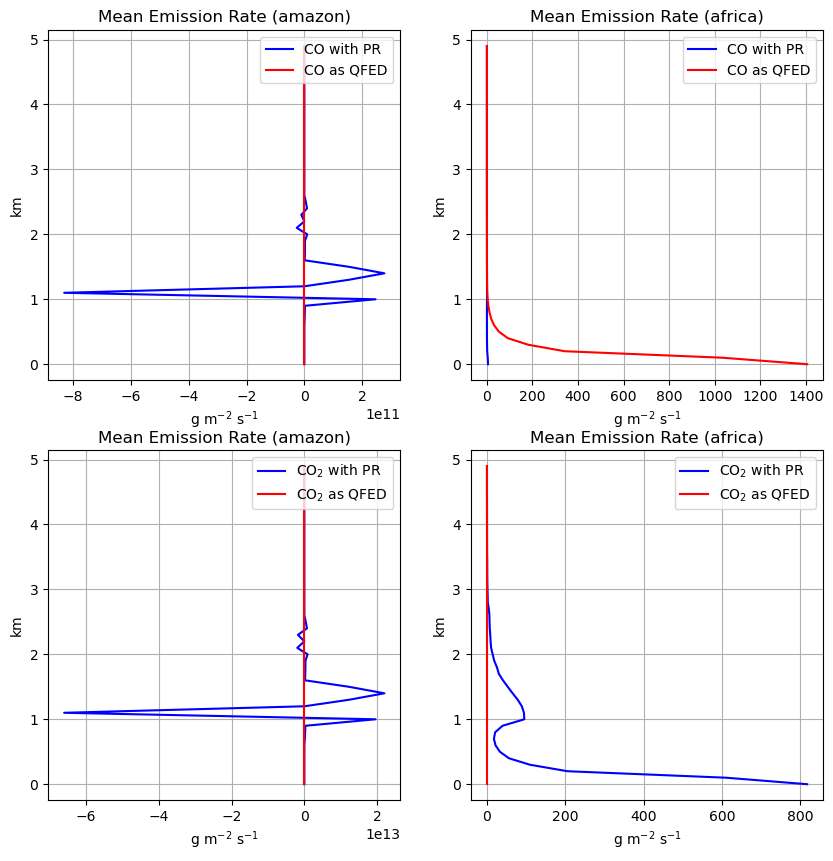

In [7]:
Rnames = list(Regions.keys())

z = p.z_plume.values / 1000.
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Emean(z,'Mean Emission Rate ('+Rnames[0]+')', r'g m$^{-2}$ s$^{-1}$', meanE_co[0], 'CO with PR', meanqE_co[0], 'CO as QFED')
plt.subplot(222)
plot_Emean(z,'Mean Emission Rate ('+Rnames[1]+')', r'g m$^{-2}$ s$^{-1}$', meanE_co[1], 'CO with PR', meanqE_co[1], 'CO as QFED')
plt.subplot(223)
plot_Emean(z,'Mean Emission Rate ('+Rnames[0]+')', r'g m$^{-2}$ s$^{-1}$', meanE_co2[0], r'CO$_2$ with PR', meanqE_co2[0], r'CO$_2$ as QFED')
plt.subplot(224)
plot_Emean(z,'Mean Emission Rate ('+Rnames[1]+')', r'g m$^{-2}$ s$^{-1}$', meanE_co2[1], r'CO$_2$ with PR', meanqE_co2[1], r'CO$_2$ as QFED')

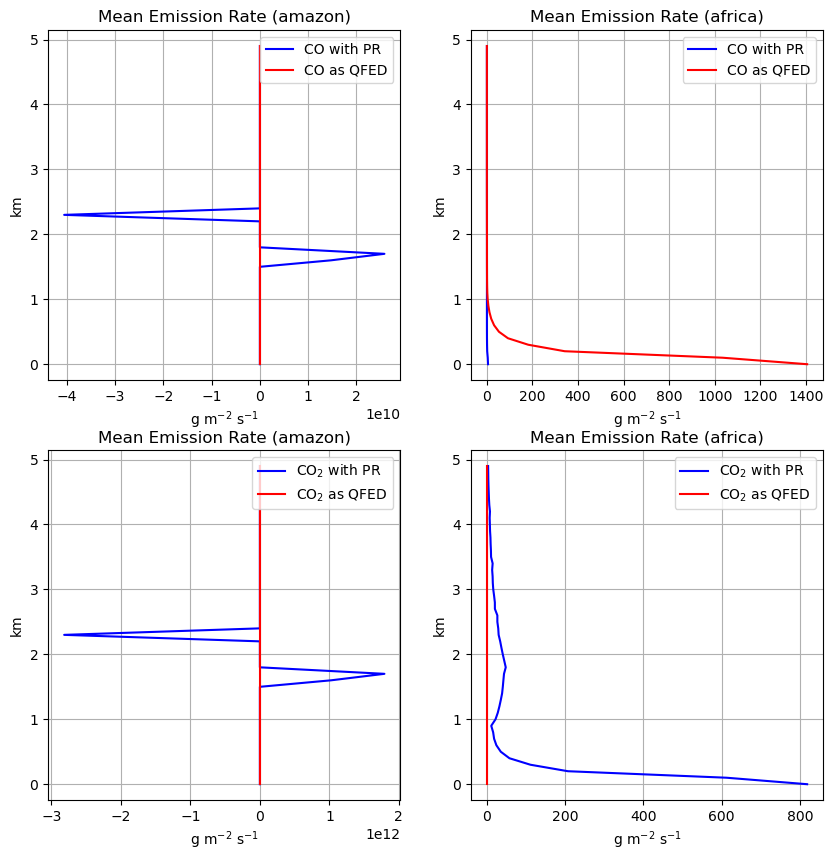

In [8]:
z = p.z_plume.values / 1000.
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Emean(z,'Mean Emission Rate ('+Rnames[0]+')', r'g m$^{-2}$ s$^{-1}$', meanE_co_20ha[0], 'CO with PR', meanqE_co_20ha[0], 'CO as QFED')
plt.subplot(222)
plot_Emean(z,'Mean Emission Rate ('+Rnames[1]+')', r'g m$^{-2}$ s$^{-1}$', meanE_co_20ha[1], 'CO with PR', meanqE_co_20ha[1], 'CO as QFED')
plt.subplot(223)
plot_Emean(z,'Mean Emission Rate ('+Rnames[0]+')', r'g m$^{-2}$ s$^{-1}$', meanE_co2_20ha[0], r'CO$_2$ with PR', meanqE_co2_20ha[0], r'CO$_2$ as QFED')
plt.subplot(224)
plot_Emean(z,'Mean Emission Rate ('+Rnames[1]+')', r'g m$^{-2}$ s$^{-1}$', meanE_co2_20ha[1], r'CO$_2$ with PR', meanqE_co2_20ha[1], r'CO$_2$ as QFED')

NpzFile './VNP47MCBEF.PR_KDE.npz' with keys: bins_F, bins_P, PBLH, Z_F, nZ_F...